## Customer Segmentation & Personality Analysis

### Recap

In the previous notebook, we have observed instances in which some features are more positively or negatively correlated. 

To reduce the multicollinearity in the modelling, we will be performing dimensionality reduction on the features. Specifically, we will be using the Principal Component Analysis (PCA) to identify crucial relationships among features in the dataset, transform existing features based on these relationships, followed by quantifying the importance of the relationships.

### 1. Introduction

Let's first import the relevant packages and dataset. 

In [1]:
# import the relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering

pd.set_option('display.max_columns', None)
sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

warnings.filterwarnings('ignore')

In [2]:
# import dataset
customer_df = pd.read_csv('../datasets/customer_cleaned.csv')

# view shape
print(f'There are {customer_df.shape[0]} rows and {customer_df.shape[1]} columns in the Customer dataset.')

# view the top 5 rows
customer_df.head()

There are 2240 rows and 30 columns in the Customer dataset.


ID   Income  Recency  MntWines  MntFruits  MntMeatProducts  \
0  5524  58138.0       58       635         88              546   
1  2174  46344.0       38        11          1                6   
2  4141  71613.0       26       426         49              127   
3  6182  26646.0       26        11          4               20   
4  5324  58293.0       94       173         43              118   

   MntFishProducts  MntSweetProducts  MntGoldProds  NumDealsPurchases  \
0              172                88            88                  3   
1                2                 1             6                  2   
2              111                21            42                  1   
3               10                 3             5                  2   
4               46                27            15                  5   

   NumWebPurchases  NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  \
0                8                   10                  4                7.0   
1                1                    1                  2                5.0   
2                8                    2                 10                4.0   
3                2                    0                  4                6.0   
4                5                    3                  6                5.0   

   AcceptedCmp3  AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  \
0             0             0             0             0             0   
1             0             0             0             0             0   
2             0             0             0             0             0   
3             0             0             0             0             0   
4             0             0             0             0             0   

   Complain  Response  age_years  total_kids  total_amt_spent  \
0         0         1       65.0           0           1617.0   
1         0         0       68.0           2             27.0   
2         0         0       57.0           0            776.0   
3         0         0       38.0           1             53.0   
4         0         0       41.0           1            422.0   

   total_num_purchases  tenure_in_days  education_level  living_status  \
0                 25.0            3612                0              0   
1                  6.0            2766                0              0   
2                 21.0            3113                0              1   
3                  8.0            2706                0              1   
4                 19.0            2962                0              1   

   has_kids  family_size  
0         0            1  
1         1            3  
2         0            2  
3         1            3  
4         1            3

In [3]:
# create a backup copy of customer_df
customer_backup_df = customer_df.copy()

# drop 'ID' from customer_df
customer_df = customer_df.drop('ID', axis=1)

### 2. Simple EDA

In this section, let's do a simple Exploratory Data Analysis (EDA) and understand the amount of multicollinearity among the features within a multiple regression, using the Variance Inflation Factor (VIF).

In [4]:
# check data type and for null values
customer_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Income               2240 non-null   float64
 1   Recency              2240 non-null   int64  
 2   MntWines             2240 non-null   int64  
 3   MntFruits            2240 non-null   int64  
 4   MntMeatProducts      2240 non-null   int64  
 5   MntFishProducts      2240 non-null   int64  
 6   MntSweetProducts     2240 non-null   int64  
 7   MntGoldProds         2240 non-null   int64  
 8   NumDealsPurchases    2240 non-null   int64  
 9   NumWebPurchases      2240 non-null   int64  
 10  NumCatalogPurchases  2240 non-null   int64  
 11  NumStorePurchases    2240 non-null   int64  
 12  NumWebVisitsMonth    2240 non-null   float64
 13  AcceptedCmp3         2240 non-null   int64  
 14  AcceptedCmp4         2240 non-null   int64  
 15  AcceptedCmp5         2240 non-null   i

In [5]:
# check for multi-collinearity
vif_df = pd.DataFrame()
vif_df['feature'] = customer_df.columns
vif_df['collinearity'] = [variance_inflation_factor(customer_df.values, i) for i in range(len(customer_df.columns))]

# view multi-collinearity
vif_df

feature  collinearity
0                Income      5.251322
1               Recency      1.070324
2              MntWines     22.029662
3             MntFruits      2.161954
4       MntMeatProducts     11.340707
5       MntFishProducts      2.765144
6      MntSweetProducts      2.158829
7          MntGoldProds      2.025427
8     NumDealsPurchases      7.350358
9       NumWebPurchases     16.651727
10  NumCatalogPurchases     14.820566
11    NumStorePurchases     23.194497
12    NumWebVisitsMonth      3.038453
13         AcceptedCmp3      1.170274
14         AcceptedCmp4      1.377924
15         AcceptedCmp5      1.694046
16         AcceptedCmp1      1.376543
17         AcceptedCmp2      1.161847
18             Complain      1.007501
19             Response      1.502422
20            age_years      1.172036
21           total_kids    397.558937
22      total_amt_spent     62.192521
23  total_num_purchases    108.128146
24       tenure_in_days      1.341198
25      education_level      1.090608
26        living_status    178.669159
27             has_kids      3.517738
28          family_size   2035.640315

VIF is calculated by taking the the ratio of the variance of coefficient estimate when fitting the full model divided by the variance of coefficient estimate if fitted on its own. The minimum value is 1 (which indicates no collinearity), and if the value is greater than 5, collinearity should be addressed. In other words, the higher the VIF, it means that:
- The more correlated a predictor is with other predictors;
- The more the standard error is inflated;
- The less likely it is that the coefficient will be evaluated as statistically significant.

*Source: [Ernest Tavares III (Mar 2017)](https://etav.github.io/python/vif_factor_python.html); [Pardeshi, Medium (Jul 2020)](https://towardsdatascience.com/handling-multi-collinearity-6579eb99fd81)*


An acceptable VIF is when the value is less than the maximum value of 10 and 1/1-R^2 model. 


In this scenario, we are able to group features with VIF above 10. The groups include: 
1. MntWines, MntMeatProducts, total_amt_spent *– it is likely that the higher the spending on wines and meat products, the higher the total amount of money spent*
2. NumWebPurchases, NumCatalogPurchases, NumStorePurchases, total_num_purchases *– it is likely the higher the number of purchases in each channel, the higher the number of purchases in total*
3. total_kids, living_status, family_size *– it is likely that more kids + couple (instead of alone) indicate bigger family size and therefore leading to more purchases*

Let's drop the features `total_kids` and `living_status` under Group 3, and review the multicollinearity scores.

In [6]:
# drop features under Group 3
customer_df = customer_df.drop(columns=['total_kids', 'living_status'])

In [7]:
# check for multi-collinearity again
vif_test_df = pd.DataFrame()
vif_test_df['feature'] = customer_df.columns
vif_test_df['collinearity'] = ([variance_inflation_factor(customer_df.values, i) 
                                for i in range(len(customer_df.columns))])

# view multi-collinearity
vif_test_df

feature  collinearity
0                Income     33.902901
1               Recency      4.124946
2              MntWines     39.925367
3             MntFruits      3.106131
4       MntMeatProducts     17.506827
5       MntFishProducts      4.070326
6      MntSweetProducts      3.082916
7          MntGoldProds      3.467553
8     NumDealsPurchases     17.825311
9       NumWebPurchases     52.292646
10  NumCatalogPurchases     26.925513
11    NumStorePurchases     96.248900
12    NumWebVisitsMonth     18.928748
13         AcceptedCmp3      1.249659
14         AcceptedCmp4      1.487086
15         AcceptedCmp5      1.817547
16         AcceptedCmp1      1.465246
17         AcceptedCmp2      1.177459
18             Complain      1.014554
19             Response      1.731290
20            age_years     23.238546
21      total_amt_spent    124.931517
22  total_num_purchases    516.203583
23       tenure_in_days     67.335795
24      education_level      1.229911
25             has_kids      9.558310
26          family_size     20.065489

After dropping the features `total_kids` and `living_status`, it seems that the VIF of other features still remain high. 

Let's transform the features to a common scale using Standard Scaler, followed by utilizing dimensionality reduction to reduce multi-collinearity among the remaining features.

In [8]:
# instantiate StandardScaler
ss = StandardScaler()
ss.fit(customer_df)
customer_sc_df = pd.DataFrame(ss.transform(customer_df), columns=customer_df.columns)

# view scaled data
customer_sc_df.head()

Income   Recency  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
0  0.316531  0.307039  0.983781   1.551577         1.679702         2.462147   
1 -0.257100 -0.383664 -0.870479  -0.636301        -0.713225        -0.650449   
2  0.971922 -0.798086  0.362723   0.570804        -0.177032         1.345274   
3 -1.215162 -0.798086 -0.870479  -0.560857        -0.651187        -0.503974   
4  0.324070  1.550305 -0.389085   0.419916        -0.216914         0.155164   

   MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  \
0          1.476500      0.843207           0.349414         1.409304   
1         -0.631503     -0.729006          -0.168236        -1.110409   
2         -0.146905     -0.038766          -0.685887         1.409304   
3         -0.583043     -0.748179          -0.168236        -0.750450   
4         -0.001525     -0.556446           1.384715         0.329427   

   NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  \
0             2.510890          -0.550785           0.752799      -0.28014   
1            -0.568720          -1.166125          -0.117983      -0.28014   
2            -0.226541           1.295237          -0.553374      -0.28014   
3            -0.910898          -0.550785           0.317408      -0.28014   
4             0.115638           0.064556          -0.117983      -0.28014   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Response  \
0      -0.28383      -0.28014     -0.262111      -0.11651 -0.097282  2.388846   
1      -0.28383      -0.28014     -0.262111      -0.11651 -0.097282 -0.418612   
2      -0.28383      -0.28014     -0.262111      -0.11651 -0.097282 -0.418612   
3      -0.28383      -0.28014     -0.262111      -0.11651 -0.097282 -0.418612   
4      -0.28383      -0.28014     -0.262111      -0.11651 -0.097282 -0.418612   

   age_years  total_amt_spent  total_num_purchases  tenure_in_days  \
0   1.018098         1.695603             1.332458        1.976745   
1   1.274694        -0.963045            -1.158512       -1.667011   
2   0.333842         0.289362             0.808043       -0.172468   
3  -1.291266        -0.919570            -0.896304       -1.925433   
4  -1.034670        -0.302563             0.545836       -0.822831   

   education_level  has_kids  family_size  
0        -0.360002 -1.584605    -1.759115  
1        -0.360002  0.631072     0.446548  
2        -0.360002 -1.584605    -0.656283  
3        -0.360002  0.631072     0.446548  
4        -0.360002  0.631072     0.446548

### 3. Dimensionality Reduction

In this section, we will be using the Principal Component Analysis (PCA) method to combine highly correlated variables (containing 'redundant' information) into single variables. 

In [9]:
# instantiate PCA
pca = PCA(random_state=42)

# fit PCA on the DataFrame
pca.fit(customer_sc_df)

# transform PCA on the DataFrame
customer_pca = pca.transform(customer_sc_df)

# view the resulting data
customer_pca_df = pd.DataFrame(customer_pca)
customer_pca_df.describe().T

count          mean       std       min       25%       50%       75%  \
0   2240.0  2.854859e-17  2.908208 -3.946759 -2.659744 -0.774176  2.391370   
1   2240.0 -1.320372e-16  1.559843 -4.229917 -1.103753 -0.257181  0.985054   
2   2240.0 -4.381416e-17  1.377400 -3.141122 -0.655344 -0.115663  0.253990   
3   2240.0 -6.472997e-17  1.230571 -4.113298 -0.835064 -0.084943  0.731321   
4   2240.0  1.362997e-17  1.078341 -3.886840 -0.608732 -0.001633  0.612142   
5   2240.0  3.293496e-17  1.009963 -2.019032 -0.718528 -0.052919  0.535621   
6   2240.0  3.816392e-17  1.005046 -3.286988 -0.474529 -0.050680  0.391556   
7   2240.0  2.973812e-19  0.986350 -2.978282 -0.618245 -0.080275  0.503713   
8   2240.0  4.502430e-17  0.932023 -3.219921 -0.587176 -0.095393  0.527033   
9   2240.0 -2.517827e-17  0.915971 -3.266275 -0.552465  0.036908  0.545242   
10  2240.0 -3.365364e-17  0.871757 -2.696776 -0.500196  0.015294  0.451681   
11  2240.0  4.567279e-17  0.851318 -6.864176 -0.397922 -0.057106  0.394662   
12  2240.0  6.220223e-18  0.800060 -3.181318 -0.458603 -0.033448  0.402324   
13  2240.0 -2.598368e-17  0.783851 -3.334132 -0.354136 -0.001691  0.290022   
14  2240.0  2.450916e-17  0.768572 -3.218313 -0.348942  0.059154  0.382402   
15  2240.0 -6.854636e-17  0.752616 -3.437413 -0.357669  0.021967  0.375004   
16  2240.0 -3.994820e-17  0.679328 -2.415602 -0.418254 -0.010094  0.378857   
17  2240.0 -2.428613e-17  0.663733 -2.449522 -0.333771  0.008434  0.335330   
18  2240.0  2.903184e-17  0.659729 -3.260800 -0.278383 -0.016035  0.261906   
19  2240.0  1.389018e-17  0.615230 -2.761229 -0.171164  0.004333  0.166375   
20  2240.0  1.051366e-17  0.552063 -2.718102 -0.256481  0.016556  0.284263   
21  2240.0 -1.117658e-17  0.536172 -2.357226 -0.316831 -0.011611  0.352134   
22  2240.0 -3.191891e-17  0.489047 -2.346159 -0.299102  0.005410  0.296519   
23  2240.0  5.179389e-18  0.474834 -2.434423 -0.283684  0.016921  0.273373   
24  2240.0  5.228952e-18  0.387323 -1.550590 -0.244108 -0.000697  0.235345   
25  2240.0 -4.079311e-18  0.104771 -0.115316 -0.009224 -0.000892  0.007495   
26  2240.0  1.144608e-17  0.078738 -0.643595 -0.018209  0.001802  0.017928   

         max  
0   8.134346  
1   6.021037  
2   8.912520  
3   4.823451  
4   4.964491  
5   6.332408  
6   8.442927  
7   6.487976  
8   5.391418  
9   4.778286  
10  5.193365  
11  9.696121  
12  4.662586  
13  3.769639  
14  3.927760  
15  4.867864  
16  4.155858  
17  4.853722  
18  4.979456  
19  3.468521  
20  4.200483  
21  3.673725  
22  3.567321  
23  3.555703  
24  3.731981  
25  2.805929  
26  2.377523

As the number of dimensions is not stated, the original 27 dimensions have been returned. 

In [10]:
# obtain the explained variance attribute
var_exp = pca.explained_variance_ratio_
print(f'Explained variance (first 27 components): {np.round(var_exp[:26],3)}')
print('')

# generate the cumulative explained variance.
cum_var_exp = np.cumsum(var_exp)
print(f'Cumulative explained variance (first 27 components): {np.round(cum_var_exp[:26],3)}')

Explained variance (first 27 components): [0.313 0.09  0.07  0.056 0.043 0.038 0.037 0.036 0.032 0.031 0.028 0.027
 0.024 0.023 0.022 0.021 0.017 0.016 0.016 0.014 0.011 0.011 0.009 0.008
 0.006 0.   ]

Cumulative explained variance (first 27 components): [0.313 0.403 0.473 0.529 0.573 0.61  0.648 0.684 0.716 0.747 0.775 0.802
 0.826 0.848 0.87  0.891 0.908 0.925 0.941 0.955 0.966 0.977 0.985 0.994
 0.999 1.   ]


Assuming a 95% cutoff threshold, 20 components will be required to explain 95% of the variability in the data.

In [11]:
# instantiate PCA with 20 components.
pca = PCA(n_components=20, random_state=42)

# fit PCA on the DataFrame
pca.fit(customer_sc_df)

# transform PCA on the DataFrame
customer_pca = pca.transform(customer_sc_df)

# view the resulting data
customer_pca_df = pd.DataFrame(customer_pca)
customer_pca_df.describe().T

count          mean       std       min       25%       50%       75%  \
0   2240.0  2.200621e-17  2.908208 -3.946759 -2.659744 -0.774176  2.391370   
1   2240.0 -1.017044e-16  1.559843 -4.229917 -1.103753 -0.257181  0.985054   
2   2240.0  1.387779e-18  1.377400 -3.141122 -0.655344 -0.115663  0.253990   
3   2240.0  3.444665e-17  1.230571 -4.113298 -0.835064 -0.084943  0.731321   
4   2240.0 -1.318390e-17  1.078341 -3.886840 -0.608732 -0.001633  0.612142   
5   2240.0  1.041330e-16  1.009963 -2.019032 -0.718528 -0.052919  0.535621   
6   2240.0  1.754549e-17  1.005046 -3.286988 -0.474529 -0.050680  0.391556   
7   2240.0  8.277109e-18  0.986350 -2.978282 -0.618245 -0.080275  0.503713   
8   2240.0  1.233086e-18  0.932023 -3.219921 -0.587176 -0.095393  0.527033   
9   2240.0 -2.785470e-17  0.915971 -3.266275 -0.552465  0.036908  0.545242   
10  2240.0 -3.072939e-18  0.871757 -2.696776 -0.500196  0.015294  0.451681   
11  2240.0  2.597129e-17  0.851318 -6.864176 -0.397922 -0.057106  0.394662   
12  2240.0 -1.278739e-17  0.800060 -3.181318 -0.458603 -0.033448  0.402324   
13  2240.0  2.132471e-17  0.783851 -3.334132 -0.354136 -0.001691  0.290022   
14  2240.0  4.396285e-17  0.768572 -3.218313 -0.348942  0.059154  0.382402   
15  2240.0  1.219263e-17  0.752616 -3.437413 -0.357669  0.021967  0.375004   
16  2240.0 -2.398875e-17  0.679328 -2.415602 -0.418254 -0.010094  0.378857   
17  2240.0  2.998593e-18  0.663733 -2.449522 -0.333771  0.008434  0.335330   
18  2240.0 -1.462124e-18  0.659729 -3.260800 -0.278383 -0.016035  0.261906   
19  2240.0 -1.050747e-17  0.615230 -2.761229 -0.171164  0.004333  0.166375   

         max  
0   8.134346  
1   6.021037  
2   8.912520  
3   4.823451  
4   4.964491  
5   6.332408  
6   8.442927  
7   6.487976  
8   5.391418  
9   4.778286  
10  5.193365  
11  9.696121  
12  4.662586  
13  3.769639  
14  3.927760  
15  4.867864  
16  4.155858  
17  4.853722  
18  4.979456  
19  3.468521

### 4. Clustering

In this section, we will first use the Elbow Method and K-Means Clustering to determine the number of clusters to be formed.

Thereafter, we will use Agglomerative Clustering to identify the specific groups, where the data will be split into sub-groups that are distinct from each other. Each sub-group may consist of features that distinguish them from other sub-groups. 

Number of clusters to be formed include:


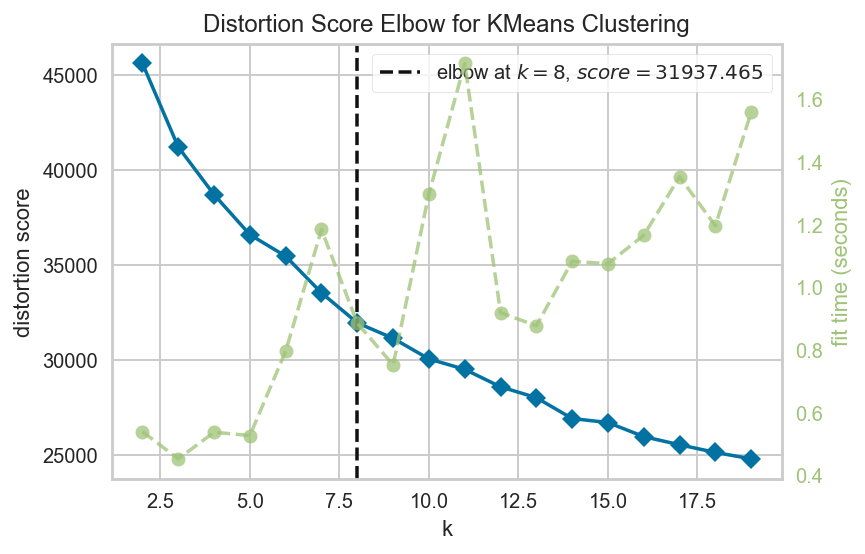

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [12]:
# instantiate KElbowVisualizater
# use 20 as max value 
print(f'Number of clusters to be formed include:')
elbow = KElbowVisualizer(KMeans(), k=(2,20))

# fit PCA on the DataFrame
elbow.fit(customer_sc_df)
elbow.show()

From the above plot, it seems that there will be an optimal number of 8 clusters for this dataset, with a score of 31,937 using the metric 'distortion', i.e. the mean sum of squared distances from each point to its assigned center.

In [13]:
# instantiate Agglomerative Clustering model 
ac = AgglomerativeClustering(n_clusters=8)

# fit model and predict clusters
yhat_ac = ac.fit_predict(customer_sc_df)

# add clusters to original dataframe
customer_sc_df['cluster'] = yhat_ac
customer_df['cluster'] = yhat_ac

# view top 5 rows with clusters
customer_df.head()

Income  Recency  MntWines  MntFruits  MntMeatProducts  MntFishProducts  \
0  58138.0       58       635         88              546              172   
1  46344.0       38        11          1                6                2   
2  71613.0       26       426         49              127              111   
3  26646.0       26        11          4               20               10   
4  58293.0       94       173         43              118               46   

   MntSweetProducts  MntGoldProds  NumDealsPurchases  NumWebPurchases  \
0                88            88                  3                8   
1                 1             6                  2                1   
2                21            42                  1                8   
3                 3             5                  2                2   
4                27            15                  5                5   

   NumCatalogPurchases  NumStorePurchases  NumWebVisitsMonth  AcceptedCmp3  \
0                   10                  4                7.0             0   
1                    1                  2                5.0             0   
2                    2                 10                4.0             0   
3                    0                  4                6.0             0   
4                    3                  6                5.0             0   

   AcceptedCmp4  AcceptedCmp5  AcceptedCmp1  AcceptedCmp2  Complain  Response  \
0             0             0             0             0         0         1   
1             0             0             0             0         0         0   
2             0             0             0             0         0         0   
3             0             0             0             0         0         0   
4             0             0             0             0         0         0   

   age_years  total_amt_spent  total_num_purchases  tenure_in_days  \
0       65.0           1617.0                 25.0            3612   
1       68.0             27.0                  6.0            2766   
2       57.0            776.0                 21.0            3113   
3       38.0             53.0                  8.0            2706   
4       41.0            422.0                 19.0            2962   

   education_level  has_kids  family_size  cluster  
0                0         0            1        7  
1                0         1            3        0  
2                0         0            2        7  
3                0         1            3        0  
4                0         1            3        1

### 5. Evaluating Models

In this section, we will be performing an evaluation on the clusters identified, using mainly their purchasing behaviours and potentially including some personal traits. 

#### 5.1 By `clusters`

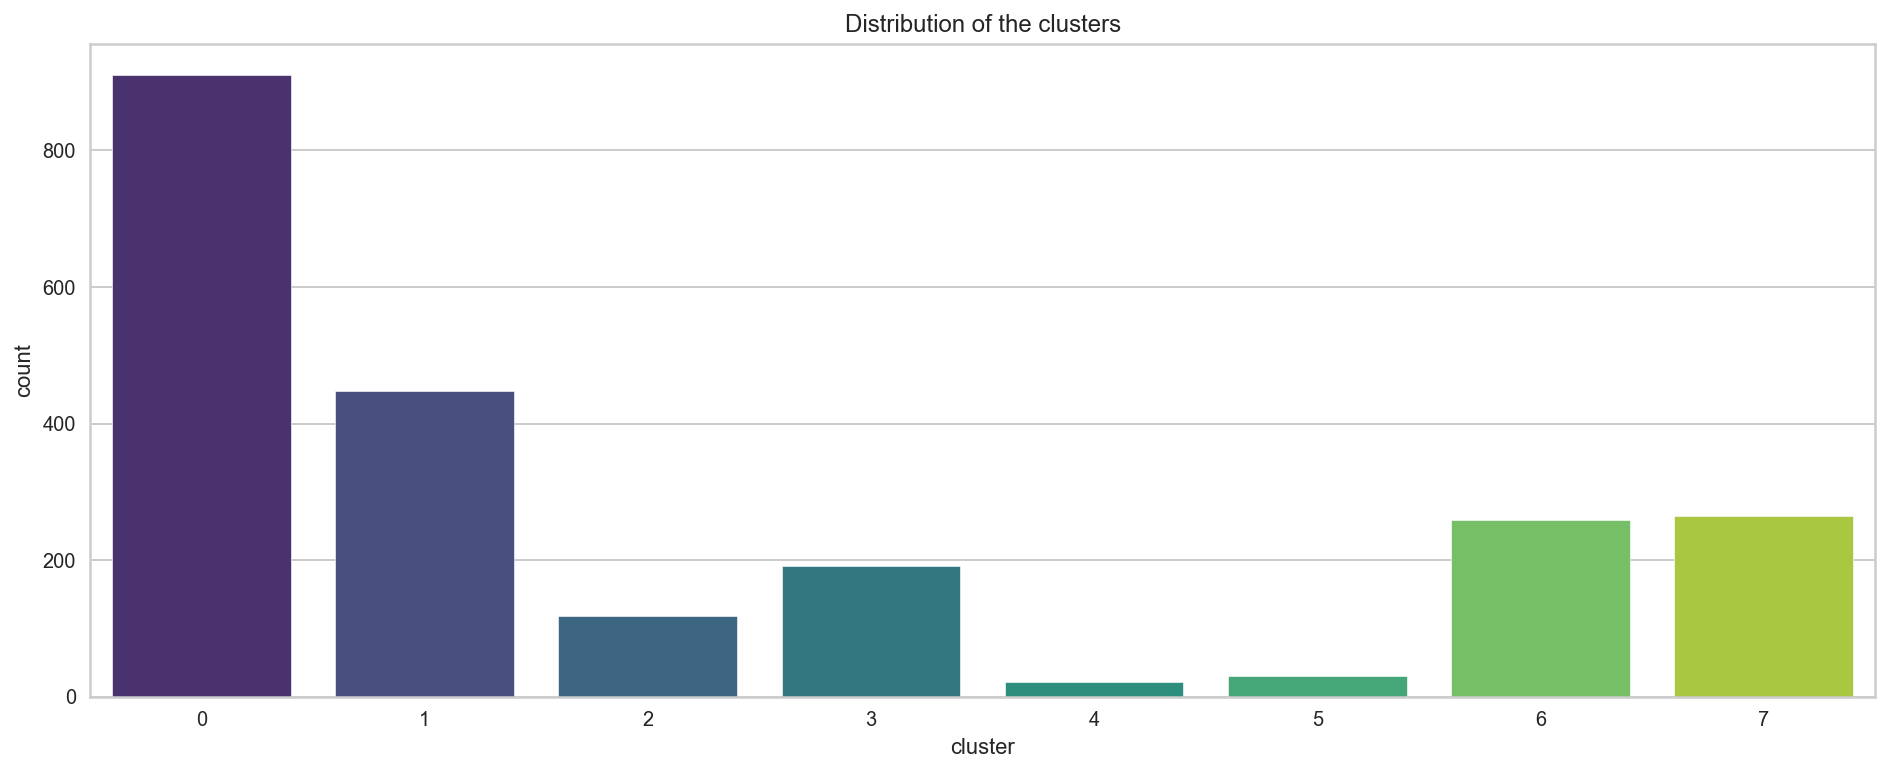

In [14]:
# plot clusters based on count 
plt.figure(figsize=(16,6))
cluster_chart = sns.countplot(x=customer_df['cluster'], palette='viridis')
cluster_chart.set_title('Distribution of the clusters')
plt.show()

In [18]:
# view count by clusters
customer_df['cluster'].value_counts(normalize=True)

0    0.406250
1    0.199554
7    0.117857
6    0.115179
3    0.085714
2    0.052679
5    0.013393
4    0.009375
Name: cluster, dtype: float64

Based on the plot of `cluster`, it can be seen that majority of customers are in Cluster 0 (40.6%), followed by Cluster 1 (20.0%), then Clusters 7 (11.8%), 6 (11.5%), 3 (8.6%), 2 (5.3%), 5 (1.3%) and 4 (0.9%). 

#### 5.2 By `Income` vs `total_amt_spent`

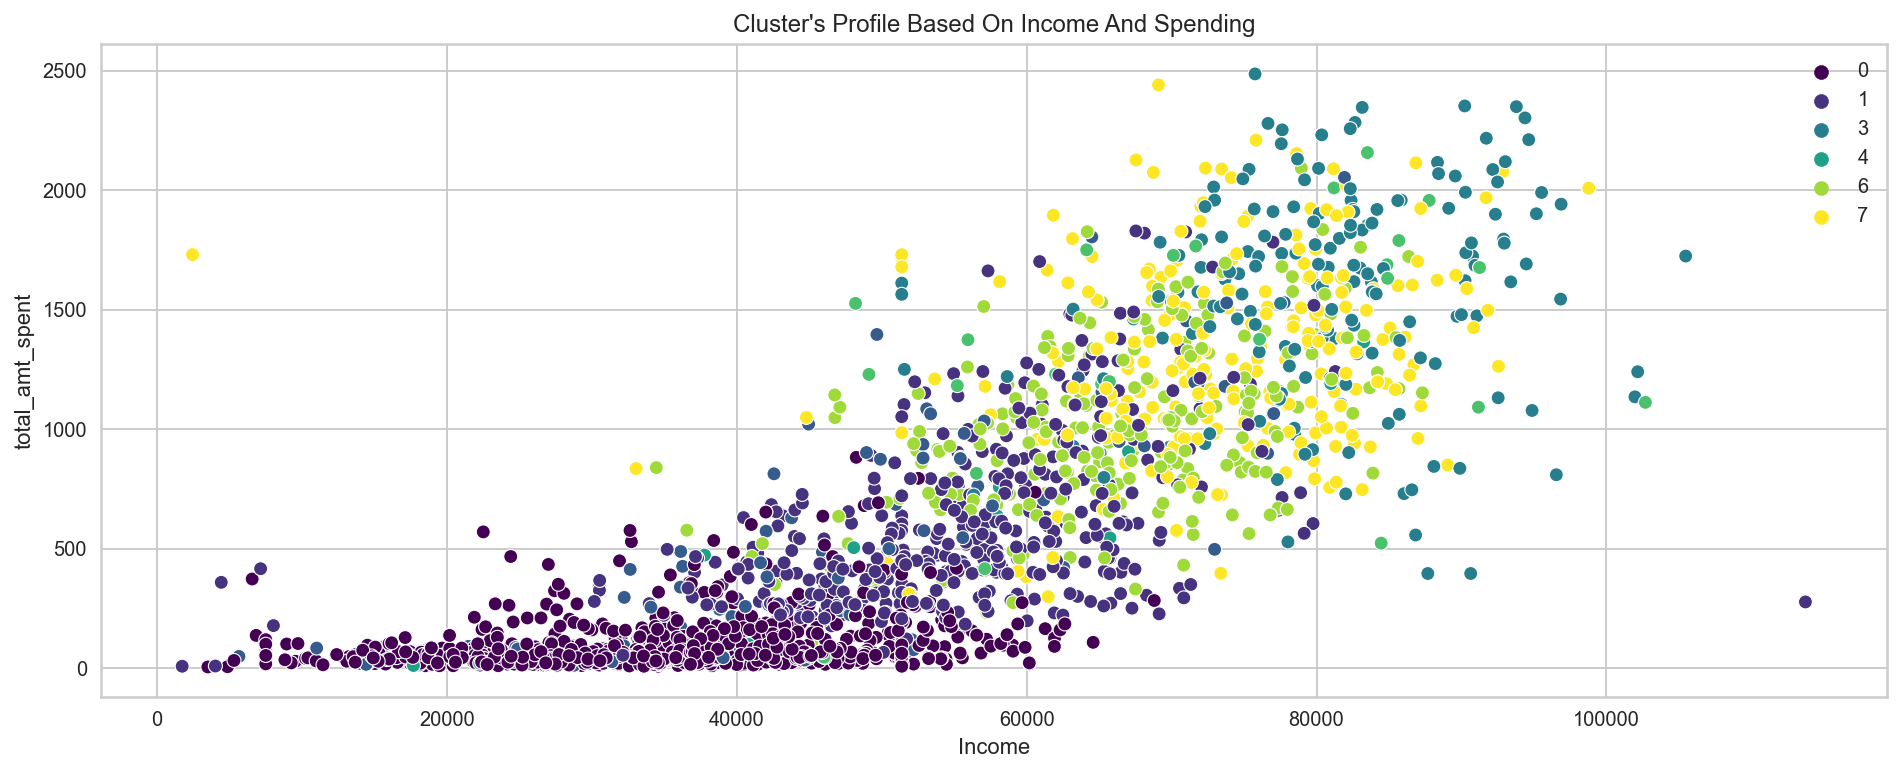

In [15]:
# plot clusters based on income vs total_spent
plt.figure(figsize=(16,6))
cluster_spend_chart = sns.scatterplot(data=customer_df, 
                                      x='Income', 
                                      y='total_amt_spent',
                                      hue='cluster',
                                      palette='viridis')
cluster_spend_chart.set_title("Cluster's Profile Based On Income And Spending")
plt.legend()
plt.show()

Based on the scatter plot, it seems that customers in Clusters 3, 4, 6 and 7 have proportionately higher income than other customers, and therefore higher willingness to spend.

On the other hand, customers in Clusters 0 and 1 are on the lower end of the spectrum for income, thus have lower spending amounts. 

Therefore, the customers can be classified into the following groupings: 
- High income and high spending: Clusters 3, 4, 5 
- Mid-to-high income and mid-to-high spending: Clusters 6, 7
- Low income and low spending: Clusters 0, 1, 2



#### 5.3 By `Income` only

In [16]:
# create a function to plot swarmplot for key fields
def create_swarmplot(y_value, title):
    plt.figure(figsize=(16,6))
    chart = sns.swarmplot(x=customer_df['cluster'],
                          y=customer_df[y_value],
                          palette='viridis')
    chart.set_title(title)

Let's take a closer look at the individual features. 

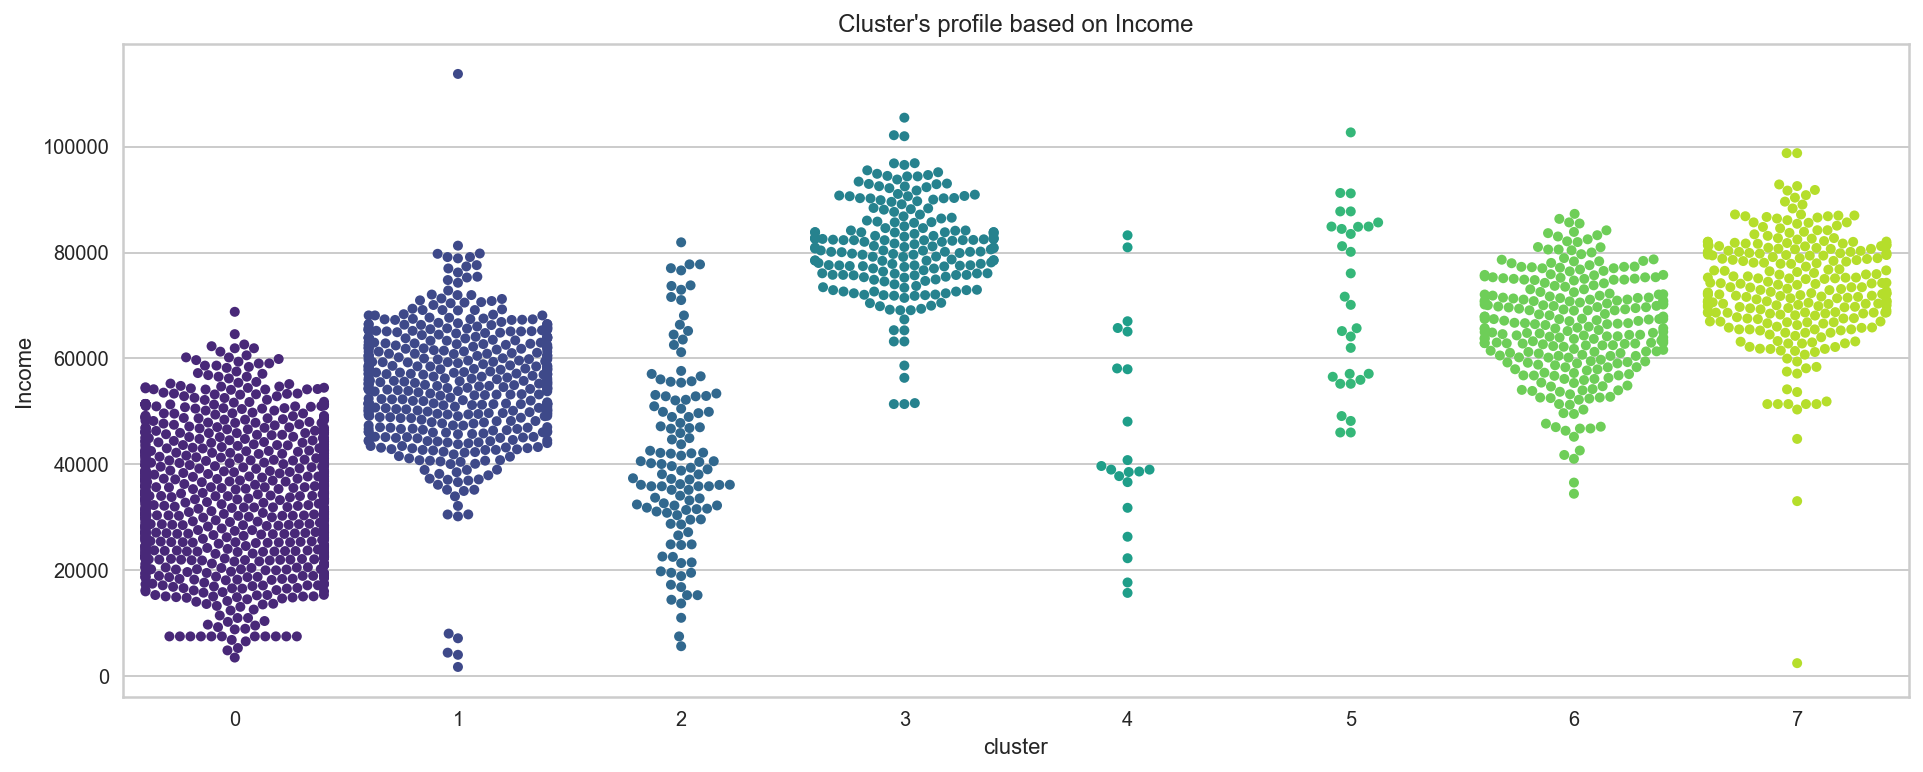

In [17]:
# plot clusters based on income
create_swarmplot(y_value='Income', title="Cluster's profile based on Income")

Based on `Income`, the following groups can be identified: 
- High income (>\\$75,000): Clusters 3, 5
- Mid income (\\$40,000 to \\$75,000): Clusters 1, 6, 7
- Low income (<\\$40,000): Clusters 0, 2, 4

#### 5.4 By `total_amt_spent` only

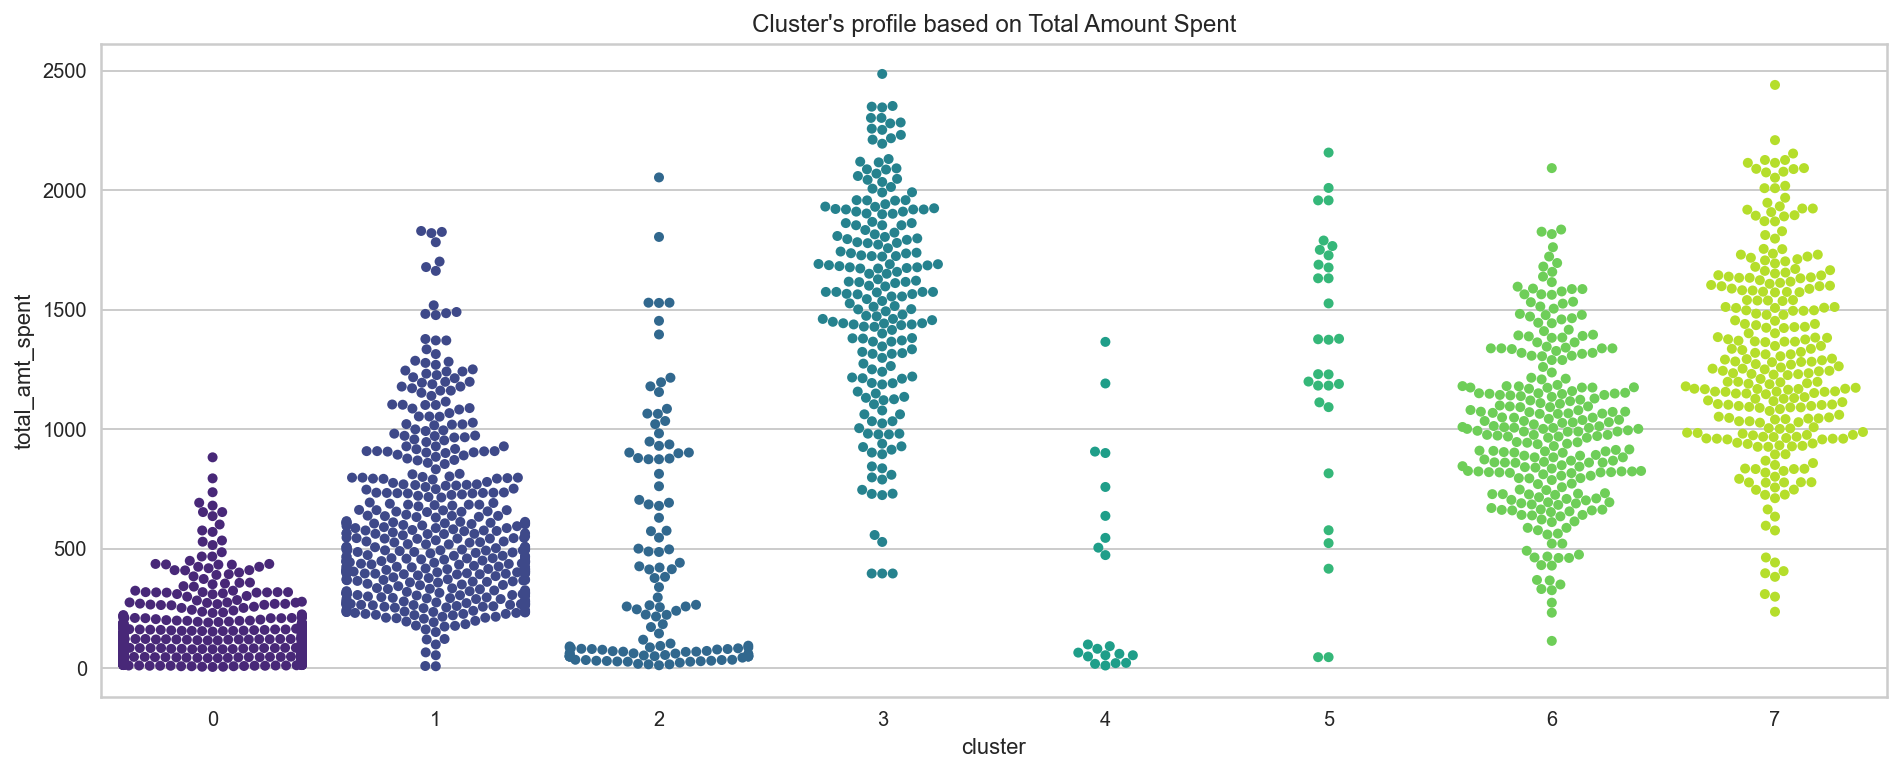

In [19]:
# plot clusters based on total_amt_spent
create_swarmplot(y_value='total_amt_spent', title="Cluster's profile based on Total Amount Spent")

Based on `total_amt_spent`, the following groups can be identified: 
- High spending (>\\$1,500): Clusters 3 
- Mid spending (\\$500 to \\$1,500): Clusters 1, 5, 6, 7
- Low spending (<\\$500): Clusters 0, 2, 4

#### 5.5 By `Recency`

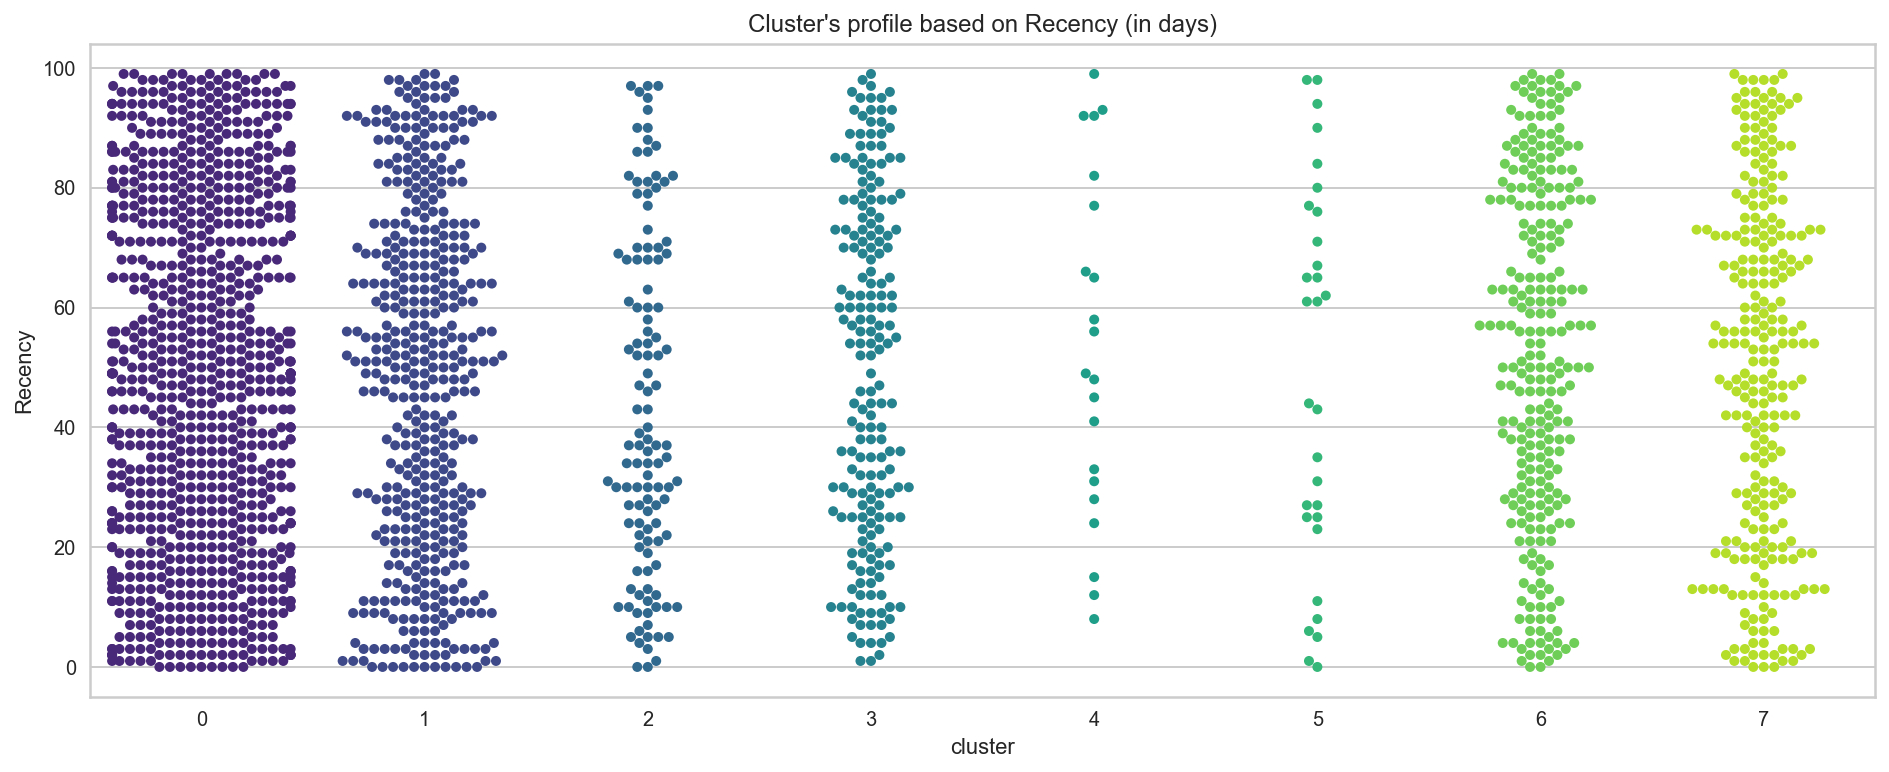

In [23]:
# plot clusters based on recency
create_swarmplot(y_value='Recency', title="Cluster's profile based on Recency (in days)")

Based on `Recency`, it seems that the values are relatively well distributed across all ranges of `Recency` values, i.e. all clusters contain customers who have purchased items recently, as well as customers who have not done so in recent times. 

#### 5.6 By `age_years`

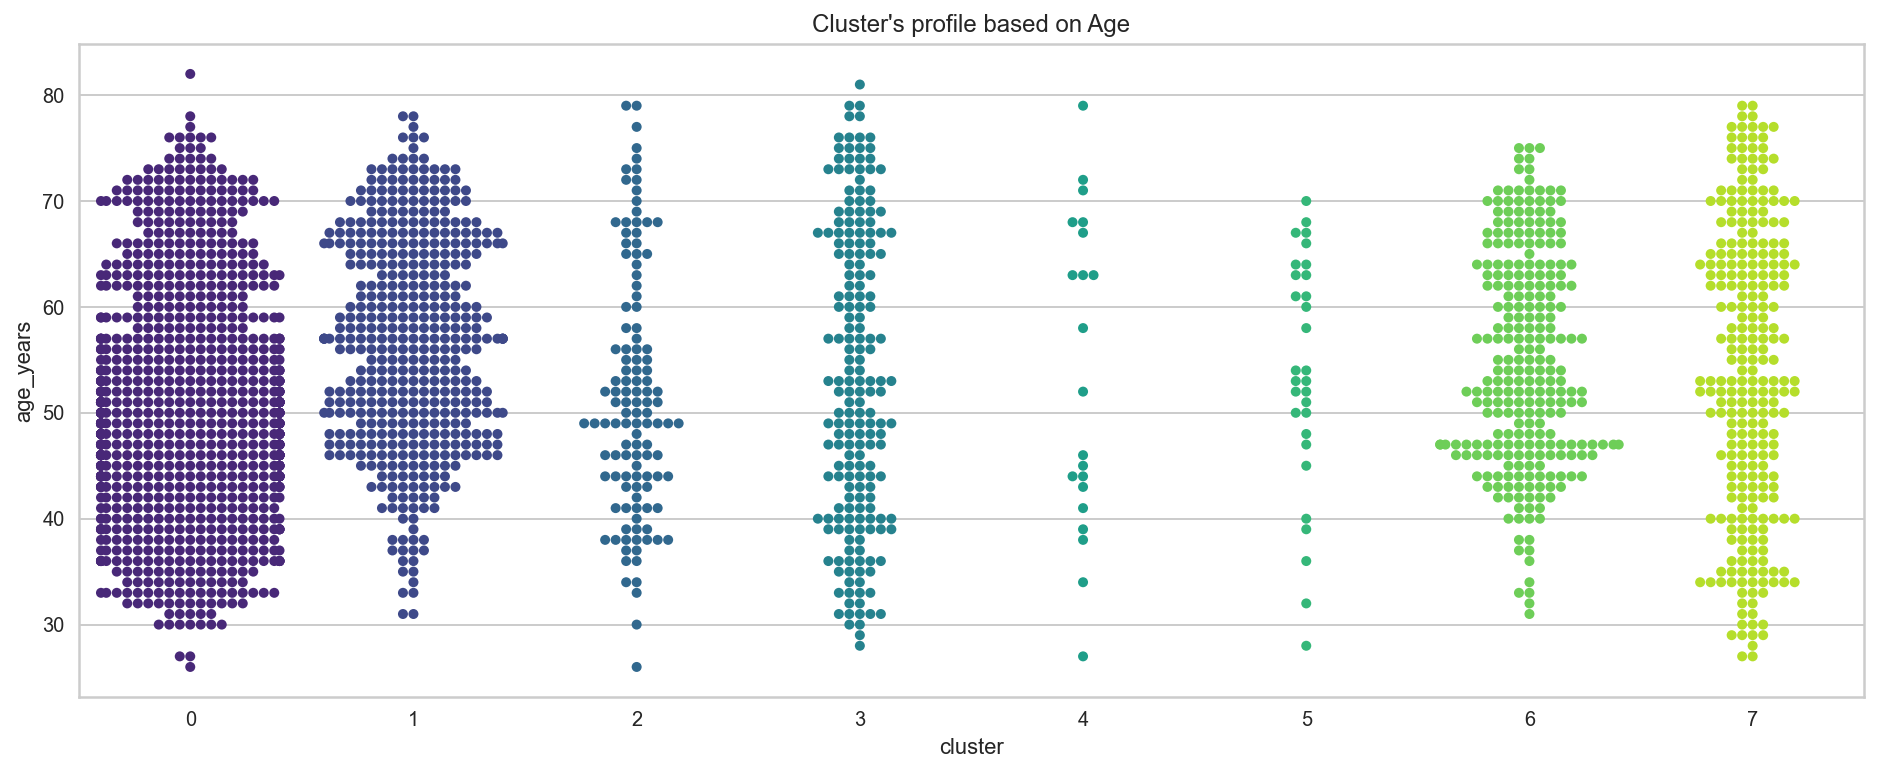

In [28]:
# plot clusters based on age
create_swarmplot(y_value='age_years', title="Cluster's profile based on Age")

Based on `age_years`, it seems that majority of customers fall between the range of 40 to 60 years old, across all clusters.
- Cluster 0 has a larger proportion of customers who are between 35 to 60 years old. 

It is interesting to note that the youngest customer is above 20 years old, while the oldest customer is slightly above 80 years old. 

#### 5.7 By `tenure_in_days`

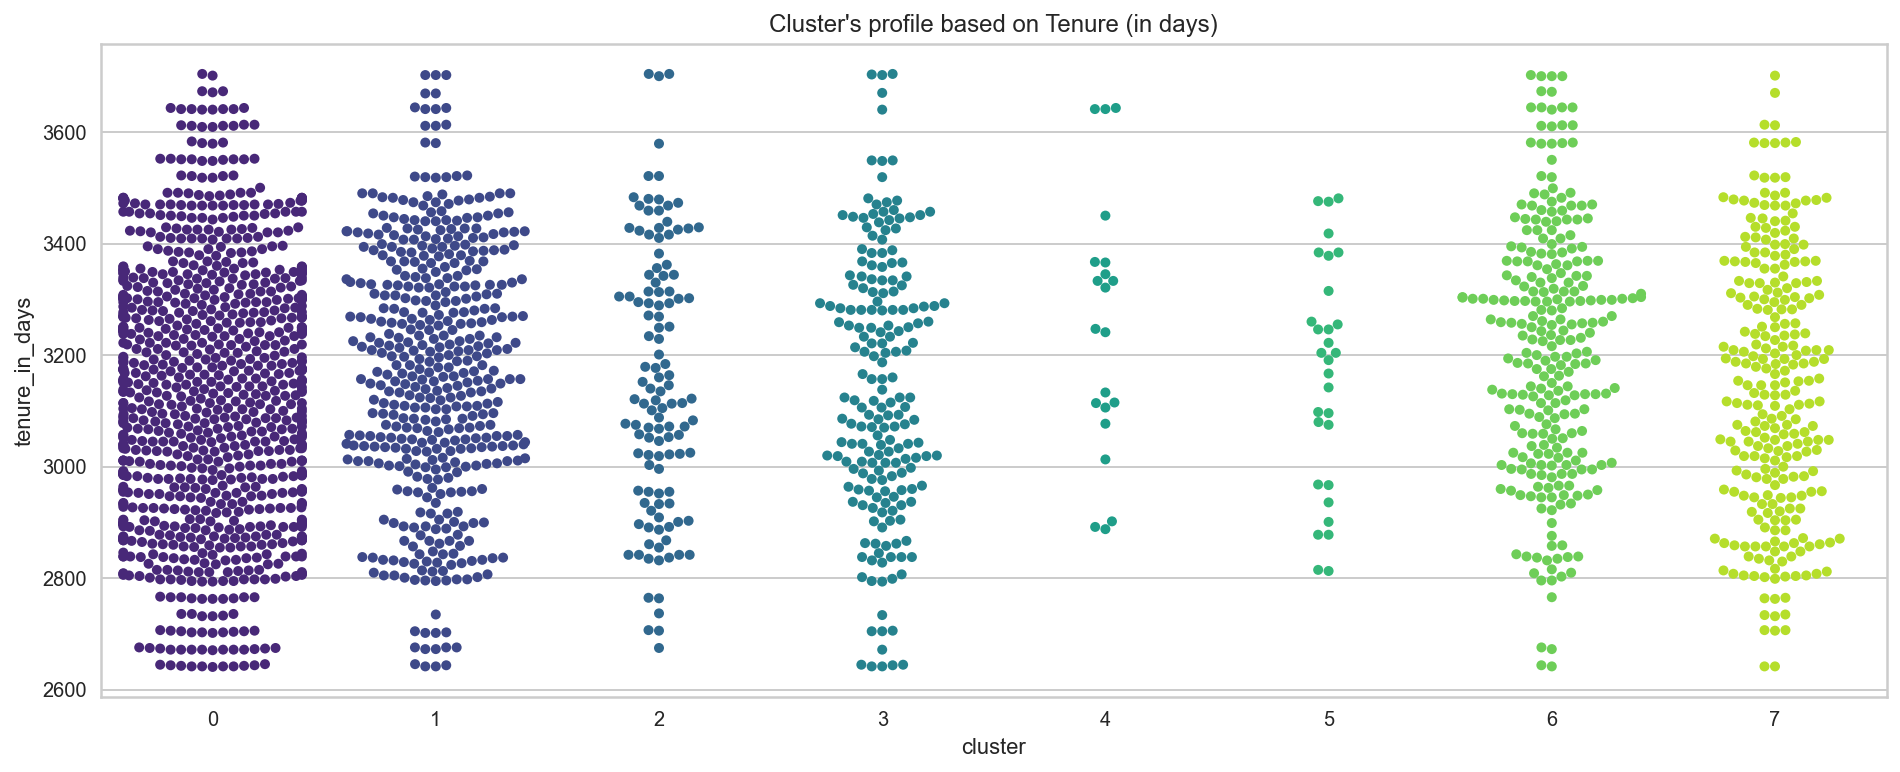

In [29]:
# plot clusters based on tenure_in_days
create_swarmplot(y_value='tenure_in_days', title="Cluster's profile based on Tenure (in days)")

Based on `tenure_in_days`, it seems that the values are relatively well distributed across all ranges of Tenure (in days) values; though it is interesting to note that majority of customers have tenures between 2,800 to 3,500 days, which can be translated to 7 to 10 years - relatively long-term customers. 

#### 5.8 By acceptance of campaigns

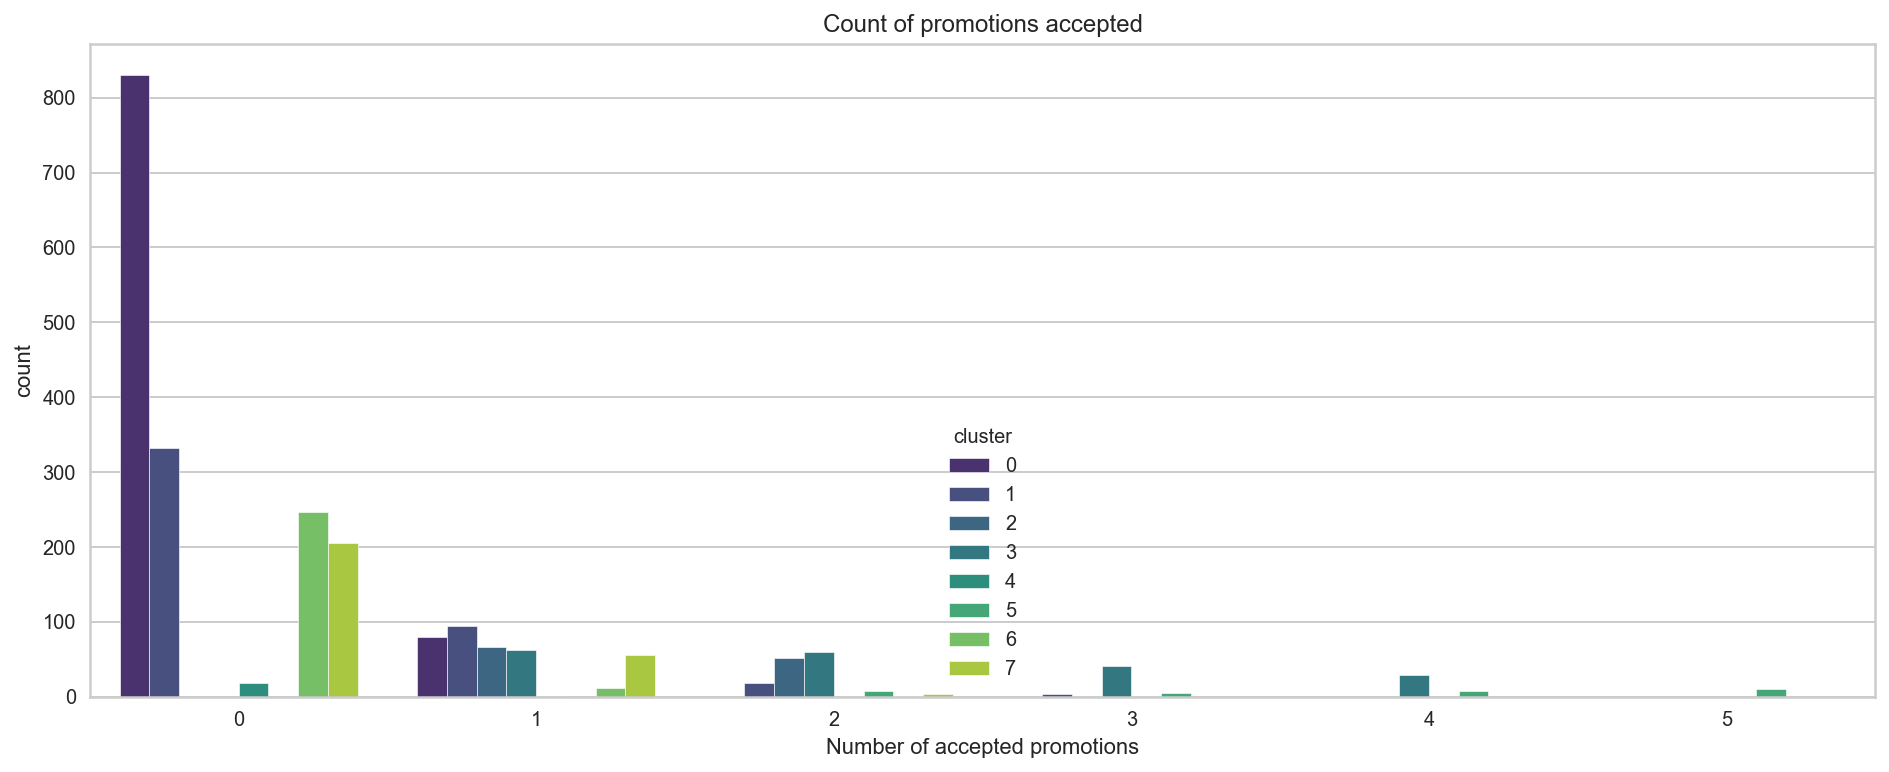

In [24]:
# create new feature to sum up acceptance of campaigns
customer_df['total_acceptedcmp'] = (customer_df['AcceptedCmp3'] + customer_df['AcceptedCmp4'] + customer_df['AcceptedCmp5']
                                    + customer_df['AcceptedCmp1'] + customer_df['AcceptedCmp2'] + customer_df['Response'])

# plot clusters based on 'total_acceptedcmp'
plt.figure(figsize=(16,6))
cluster_chart = sns.countplot(x=customer_df['total_acceptedcmp'], hue=customer_df['cluster'], palette='viridis')
cluster_chart.set_title('Count of promotions accepted')
cluster_chart.set_xlabel('Number of accepted promotions')
plt.show()

Generally, most customers are leaning towards the non-acceptance of promotions and campaigns, i.e. zero promotions. This may be due to the fact that the campaign are not aligned to their interests, or the promotion offerings are not enticing enough for their needs. Definitely, more streamlined, targeted campaigns with special offerings will need to be launched, in order to attract customers' attention and boost sales. 

However, it seems that there's a greater number of customers in Cluster 5 whom are more accepting of campaigns and promotions, i.e. responding positively to all six campaigns. This is followed by Clusters 3, 2 and 1. 

#### 5.9 By `NumDealsPurchases`

In [33]:
# create a function to plot boxenplot for key fields
def create_boxenplot(y_value, title, xlabel):
    plt.figure(figsize=(16,6))
    chart = sns.boxenplot(x=customer_df['cluster'],
                          y=customer_df[y_value],
                          palette='viridis')
    chart.set_title(title)
    chart.set_xlabel(xlabel)
    plt.show()

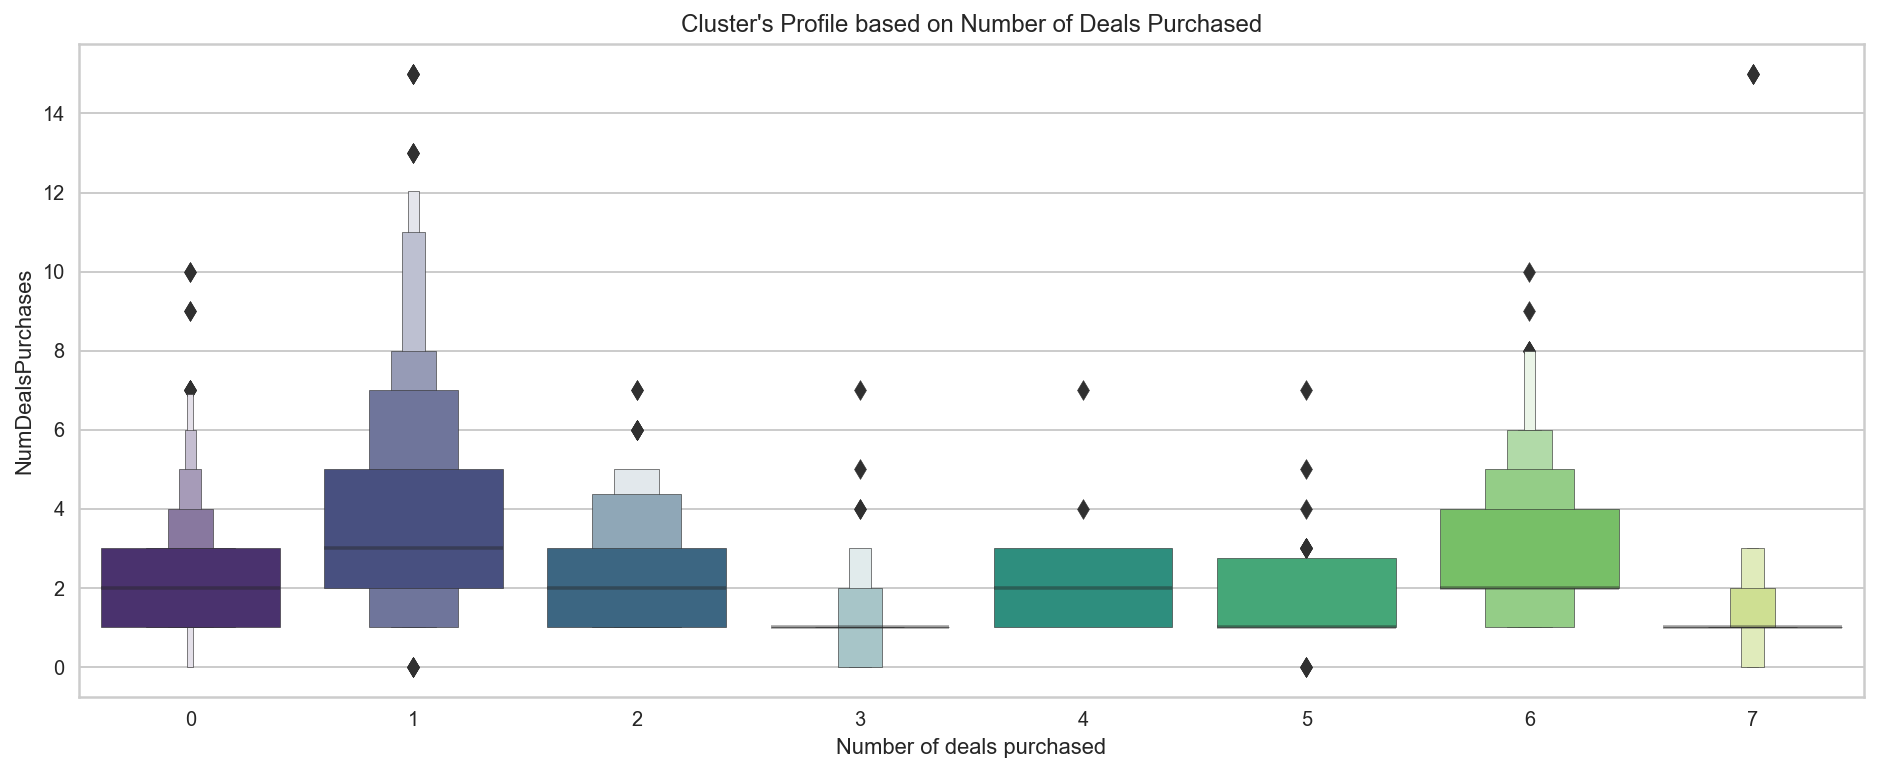

In [34]:
# plot clusters based on 'NumDealsPurchases'
create_boxenplot(y_value='NumDealsPurchases', 
                 title="Cluster's Profile based on Number of Deals Purchased", 
                 xlabel='Number of deals purchased')

From the campaigns, those who may have responded to the campaigns positively may have snagged more deals at discounted prices. 

The deals seem to resonate most positively with Cluster 1, followed by Cluster 0, 2 and 4, likely due to the fact that these clusters may be 'bargain hunters'. Clusters 3, 5 and 7 seem to react less enthusiastically to the deals. 

#### 5.10 By `total_num_purchases`

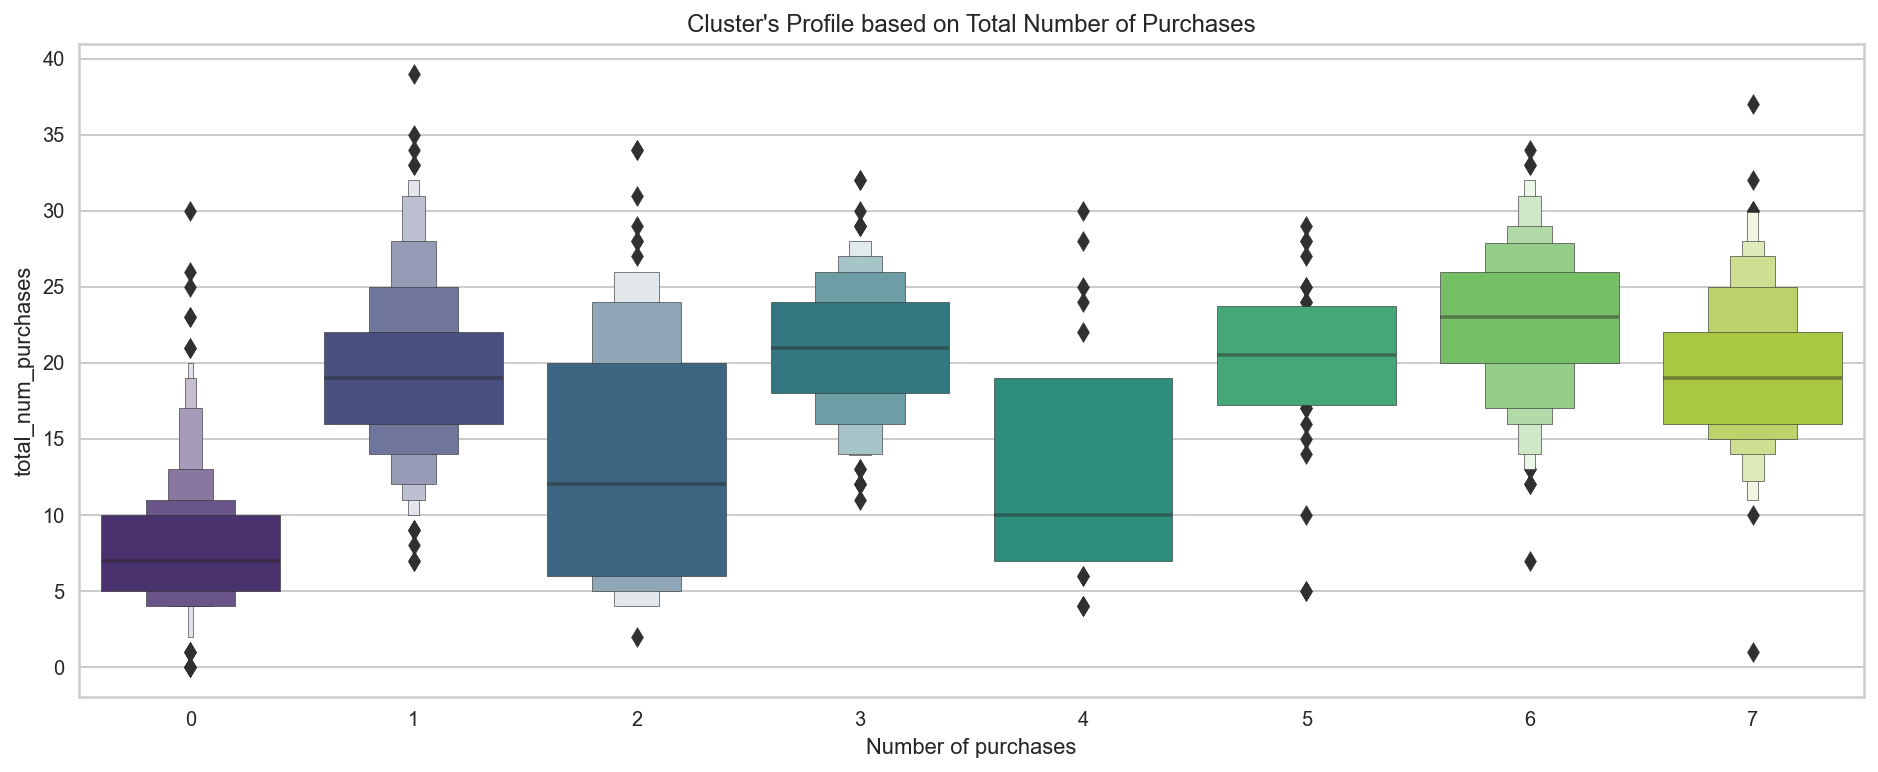

In [35]:
# plot clusters based on 'total_num_purchases'
create_boxenplot(y_value='total_num_purchases', 
                 title="Cluster's Profile based on Total Number of Purchases", 
                 xlabel='Number of purchases')

By looking at total number of purchases, it is no doubt that Clusters 6, 3, 5, 7 and 1 have relatively higher number of purchases, and that Clusters 0, 4 and 2 are falling behind in terms of the number of purchases - similar observations based on `total_amt_spent`.

### 6. Customer Profiling

In this section, we will be profiling the clusters based on the customers' personal traits, and understanding some of the key characteristics that may help SweetTreats implement more effective marketing campaigns and targeting. 

<Figure size 1152x432 with 0 Axes>

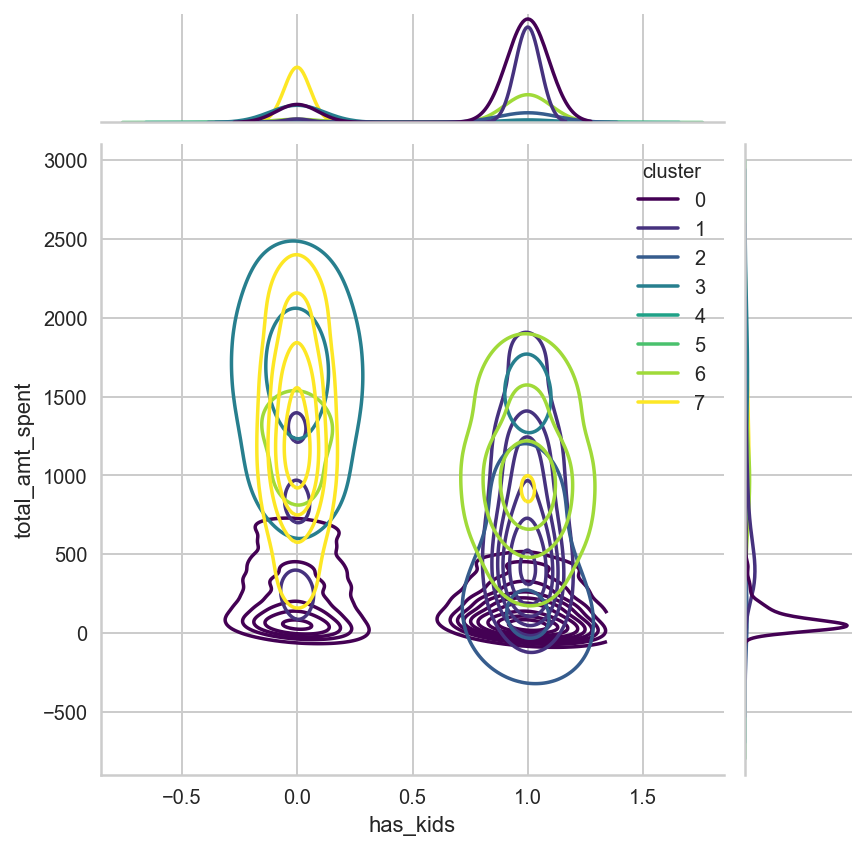

<Figure size 1152x432 with 0 Axes>

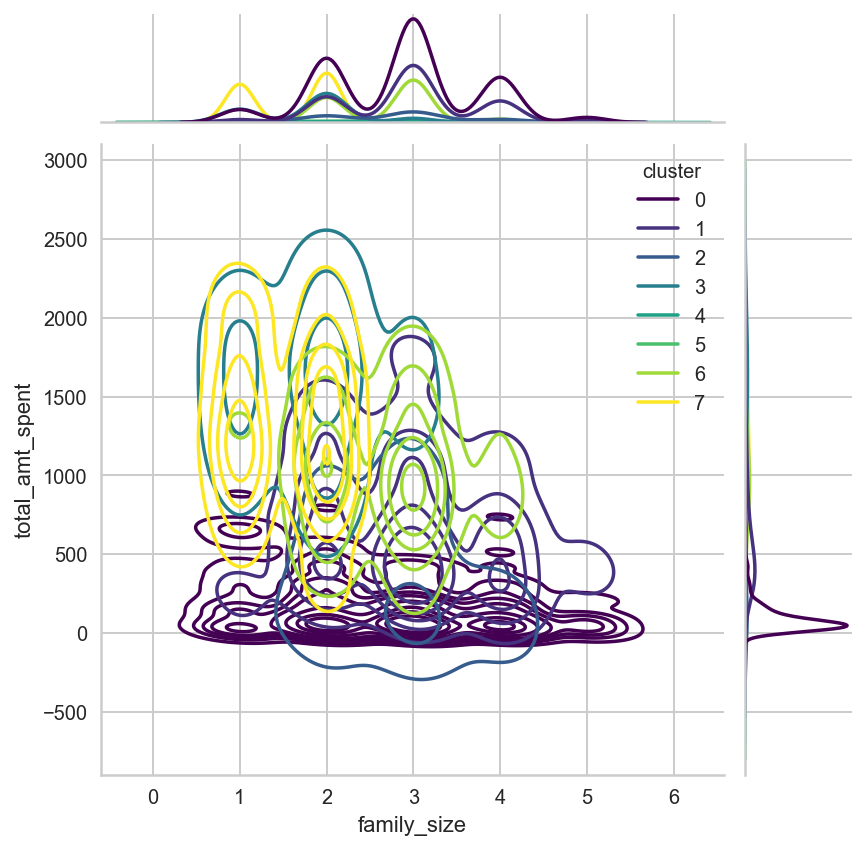

<Figure size 1152x432 with 0 Axes>

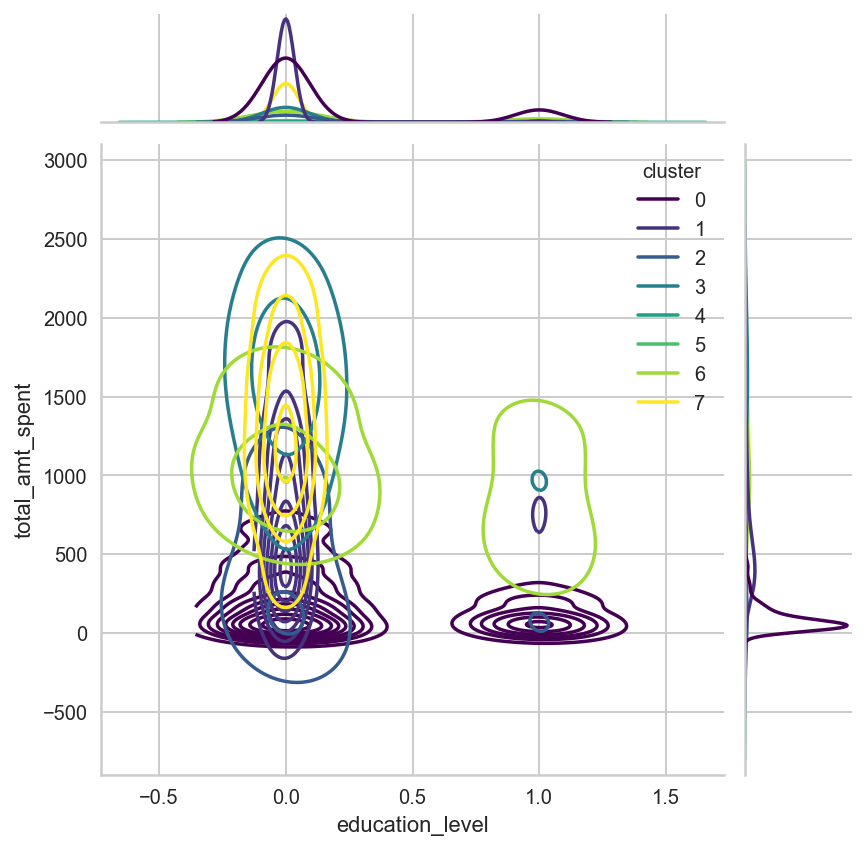

<Figure size 1152x432 with 0 Axes>

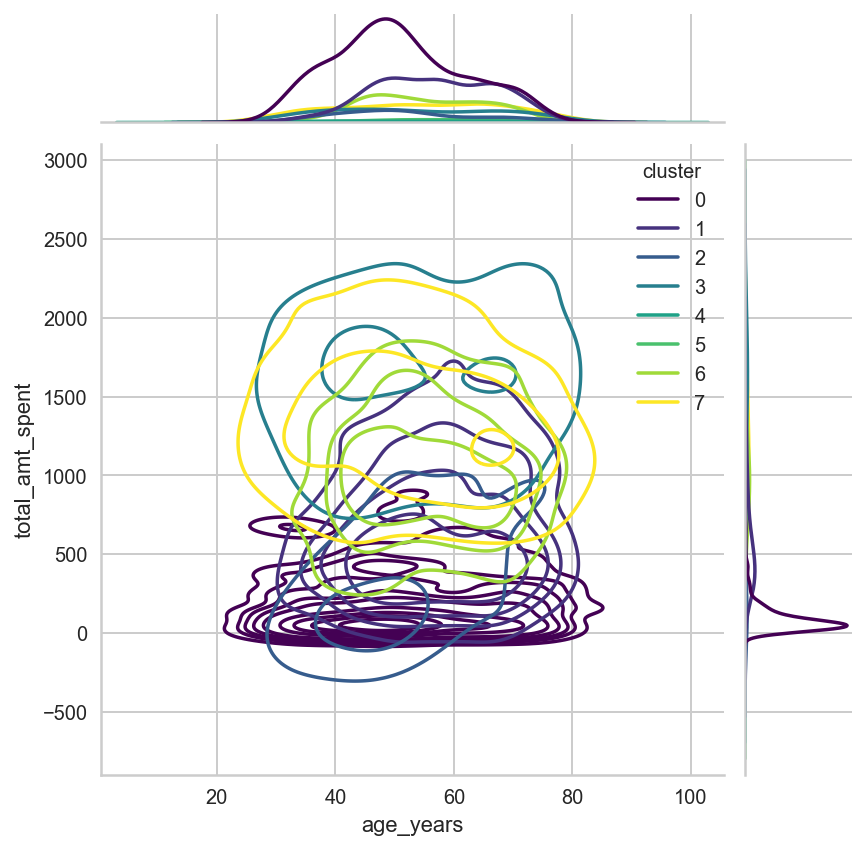

<Figure size 1152x432 with 0 Axes>

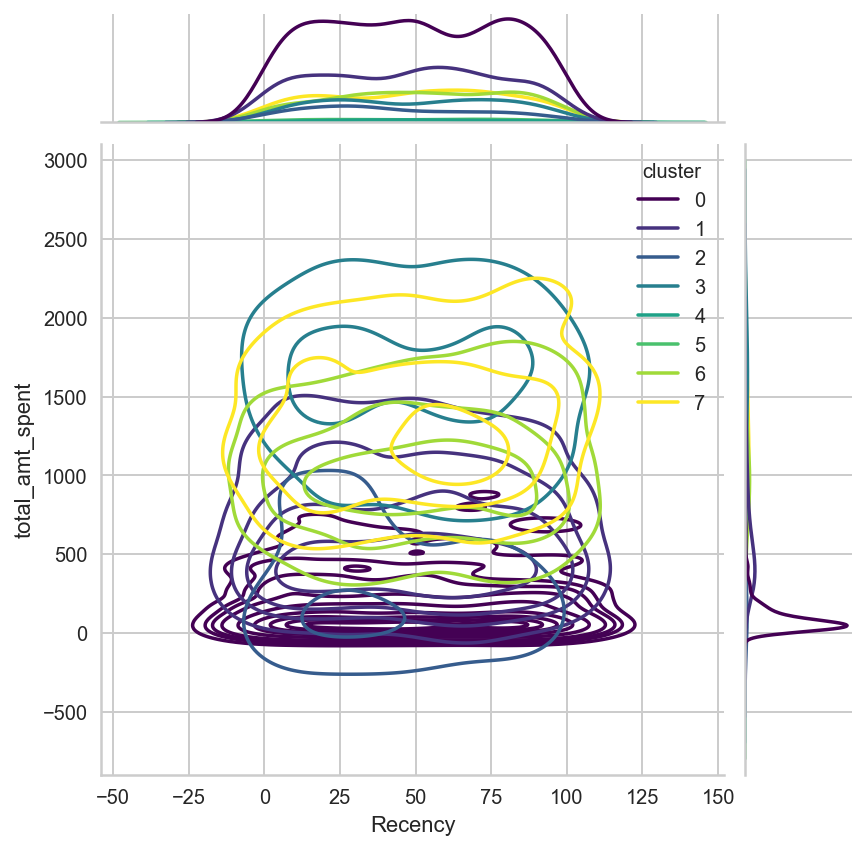

<Figure size 1152x432 with 0 Axes>

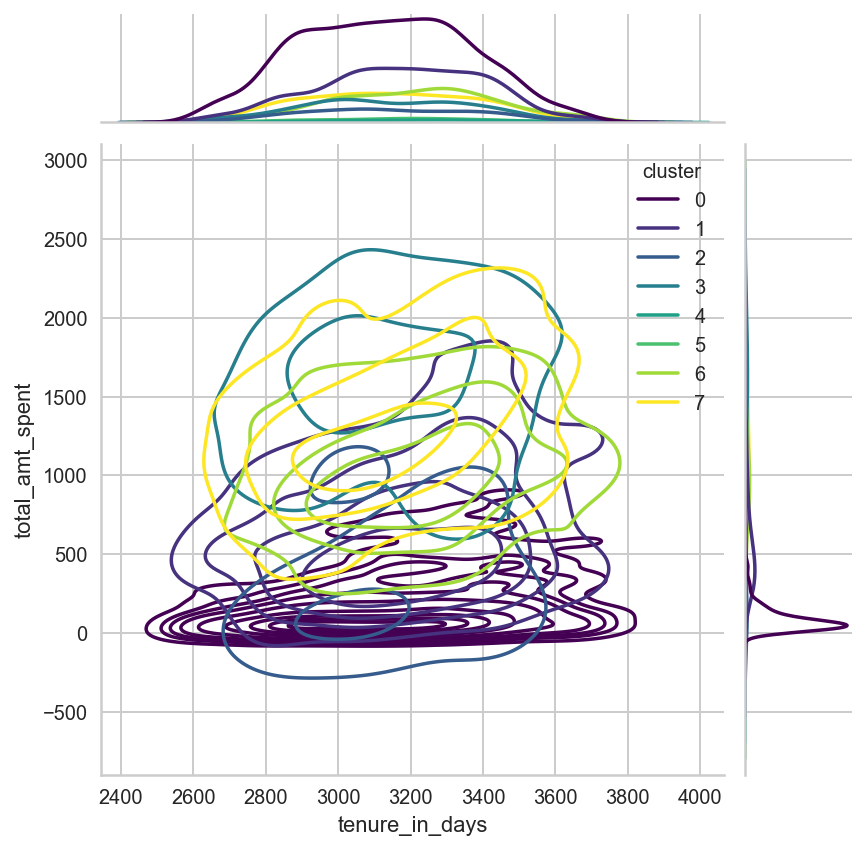

In [37]:
# store personal traits in a list
personal_traits = ['has_kids', 'family_size', 'education_level', 'age_years', 'Recency', 'tenure_in_days']

# plot clusters based on personal_traits vs total_amt_spent
for i in personal_traits:
    plt.figure()
    sns.jointplot(x=customer_df[i],
                  y=customer_df['total_amt_spent'],
                  hue=customer_df['cluster'],
                  kind='kde', 
                  palette='viridis')
    plt.show()

Some observations based on the plotting of personal traits:

- Cluster 0: 
    - A mixture of customers who have kids and no kids
    - Most have family size of 1, up to 6
    - Most customers have reached the postgrad education level, though there are some who fall under the undergrad education level 
    - Majority customers are between 40 to 60 years old
    - Most customers have their last transaction with the retailer in the past 50 days
    - Majority have been with the retailer for at least 6 years


- Cluster 1:
    - A mixture of family who have kids and no kids
    - Most have family size of 1, up to 6
    - Most customers have reached the postgrad education level
    - Majority customers are between 40 to 60 years old
    - Most customers have their last transaction with the retailer in the past 50 days
    - Majority have been with the retailer for at least 6 years


- Cluster 2: 
    - Most do not have kids
    - Most have family size of 1, up to 4
    - Most customers have reached the postgrad education level
    - Majority customers are between 40 to 60 years old
    - Most customers have their last transaction with the retailer in the past 75 days
    - Majority have been with the retailer for at least 7 years


- Cluster 3:
    - Most customers may have kids 
    - Most have family size of 1, up to 3
    - Most customers have reached the postgrad education level, though there’s a small group who fall under the undergrad education level
    - Majority customers are between 40 to 70 years old
    - Most customers have their last transaction with the retailer in the past 75 days
    - Majority have been with the retailer for at least 7 years


- Cluster 4: 
    - Most customers may have kids 
    - Most have family size of 2, up to 4
    - Most customers have reached the postgrad education level
    - Majority customers are between 40 to 60 years old 
    - Most customers have their last transaction with the retailer in the past 100 days
    - Majority have been with the retailer for at least 7 years


- Cluster 5:
    - Most customers may have kids
    - Most have family size of 2, up to 4
    - Most customers have reached the postgrad education level
    - Majority customers are between 40 to 60 years old
    - Most customers have their last transaction with the retailer in the past 90 days
    - Majority have been with the retailer for at least 7 years


- Cluster 6: 
    - Most customers do have kids 
    - Most have family size of 2, up to 4
    - Most customers have reached the postgrad education level, though there’s a moderately large group who fall under the undergrad education level 
    - Majority customers are between 40 to 70 years old
    - Most customers have their last transaction with the retailer in the past 90 days
    - Majority have been with the retailer for at least 7 years


- Cluster 7: 
    - Most do not have kids, though a small proportion has kids
    - Most have family size of 1, up to 2
    - Most customers have reached the postgrad education level
    - Majority customers are between 60 to 70 years old
    - Most customers have their last transaction with the retailer in the past 80 days
    - Majority have been with the retailer for at least 7 years

### 7. Conclusion

As a recap, SweetTreats aims to address the following issues in order to improve its revenue: 
- Can the customers of the retailer be segmented into groups for more effective targeting through marketing campaigns? 
- What are some key characteristics of each customer segment?

By looking at the purchasing habits and personal traits, the key characteristics of each customer segment and the respective marketing campaigns that can be implemented include: 


- Cluster 0: 
    - Low income and low spending - likely to be quite frugal and cautious of their spending
    - React less positively to campaigns but snag up deals 
    - Has a mixture of family who have kids and no kids, and family size of 1 up to 6
    - **Proposal: Marketing campaigns need to feature special deals / promotions with great discounts on frequently purchased items, so that customers can attain large amount of savings; campaigns can be done in-store, need not be online**


- Cluster 1: 
    - Low-to-mid income but mid spending 
    - React less positively to campaigns but snag up deals 
    - Has a mixture of family who have kids and no kids, and family size of 1 up to 6
    - **Proposal: Marketing campaigns need to feature special deals / promotions with great discounts on frequently purchased items (especially basic necessities), so that customers can attain large amount of savings; campaigns can be done in-store, need not be online**


- Cluster 2: 
    - Low income and low spending - likely to be quite frugal and cautious of their spending
    - React less positively to campaigns but snag up deals 
    - May not have kids, and family size of 1 up to 4
    - **Proposal: Marketing campaigns need to feature special deals / promotions with great discounts on frequently purchased items (especially basic necessities), so that customers can attain large amount of savings; campaigns can be done in-store, need not be online**


- Cluster 3:
    - High income and high spending 
    - React positively to campaigns, but do not snag up deals
    - Most may have kids and family size of 2 up to 4
    - **Proposal: Marketing campaigns should feature unique items that are only available to the retailer + are on a higher price point, since this group of customers has a higher purchasing propensity which makes them more adventurous to purchase new items; campaigns should be done online first to garner interest**
    
    
- Cluster 4: 
    - Low-to-mid income and low-to-mid spending 
    - React less positively to campaigns but snag up deals 
    - May not have kids, and family size of 2 up to 4
    - **Proposal: Marketing campaigns need to feature special deals / promotions with great discounts on frequently purchased items (especially basic necessities), so that customers can attain large amount of savings; campaigns can be done in-store, need not be online**


- Cluster 5:
    - High income and mid-to-high spending 
    - React positively to campaigns, but do not snag up deals
    - Most may have kids and family size of 2, up to 4
    - **Proposal: Marketing campaigns should feature unique items that are only available to the retailer + are on a higher price point, since this group of customers has a higher purchasing propensity which makes them more adventurous to purchase new items; campaigns should be done online first to garner interest**
    
    
- Cluster 6:
    - Mid income and mid spending 
    - React less positively to campaigns; do not necessarily snag up deals
    - Most may not have kids and family size of 1 up to 2 
    - **Proposal: Marketing campaigns should feature unique items that are only available to the retailer + are on a mid-to-high price point, since this group of customers has a mid purchasing propensity and are likely more adventurous to purchase new items; campaigns can be done in-store, need not be online**    
    
    
- Cluster 7:
    - Mid income and mid spending 
    - React less positively to campaigns; do not necessarily snag up deals
    - Most may not have kids and family size of 1 up to 2 
    - **Proposal: Marketing campaigns should feature unique items that are only available to the retailer + are on a mid-to-high price point, since this group of customers has a mid purchasing propensity and are likely more adventurous to purchase new items; campaigns can be done in-store, need not be online** 

### 8. Further Exploration

Some other areas that can be explored further in this project includes:
- Exploring in detail the source of purchases, i.e. web, in-store, etc. 
- Exploring other clustering methods for segmenting customers
- Deploying the model into production
    - Reference: [BentoML: Create an ML Powered Prediction Service in Minutes (Tran, Feb 2022)](https://towardsdatascience.com/bentoml-create-an-ml-powered-prediction-service-in-minutes-23d135d6ca76)
